# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay

import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true_oboa, y_true_rboa, y_pred_oboa, y_pred_rboa):
    ns_probs = [0 for _ in range(len(y_true_oboa))]
    
    #calculate fpr, tpr & thesholds for oboa, rboa, random
    fpr_oboa, tpr_oboa, thresholds_oboa = roc_curve(y_true_oboa, y_pred_oboa)
    fpr_rboa, tpr_rboa, thresholds_rboa = roc_curve(y_true_rboa, y_pred_rboa)
    fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_oboa, ns_probs)
    
    #auc calculation
    auc_oboa = auc(fpr_oboa, tpr_oboa)    
    auc_rboa = auc(fpr_rboa, tpr_rboa)
    auc_rand = auc(fpr_rand, tpr_rand)
    print('OBOA: ROC AUC=%.3f' % (auc_oboa))
    print('RBOA: ROC AUC=%.3f' % (auc_rboa))
    print('Random: ROC AUC=%.3f' % (auc_rand))
    
    #plot data
    plt.plot(fpr_oboa, tpr_oboa, marker='.', label='OBOA')
    plt.plot(fpr_rboa, tpr_rboa, marker='.', label='RBOA')
    plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y, y_p, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder_oboa = 'oboa\\'
name_tail_oboa = '_oboa'
folder_rboa = 'rboa\\'
name_tail_rboa = '_rboa'
dnnfolder = 'E1_DNN\\'

batch_sz = 256
epochsz = 100
lr = 1e-4
esp = 10
rlrp = 5

NNs = [[20, 15, 15, 8], [20, 15, 15, 15, 8]]

DNN_20_15_15_8_oboa.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (Non

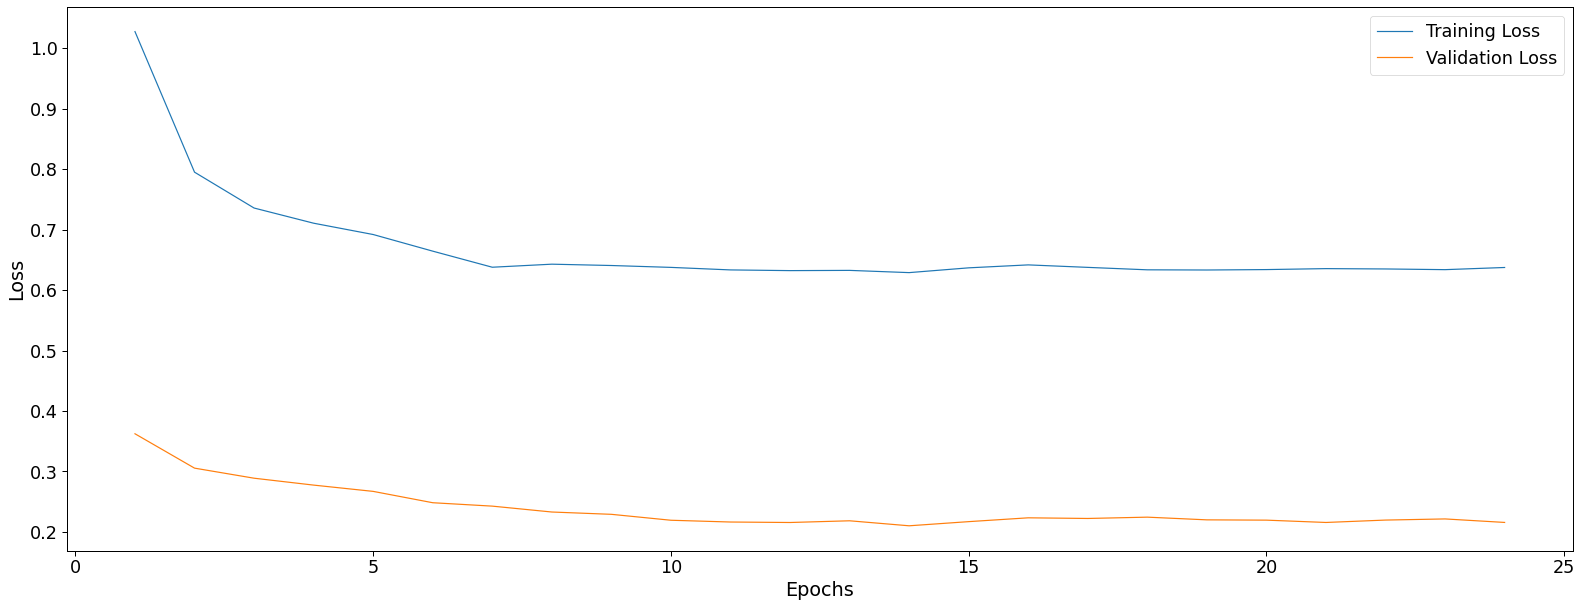

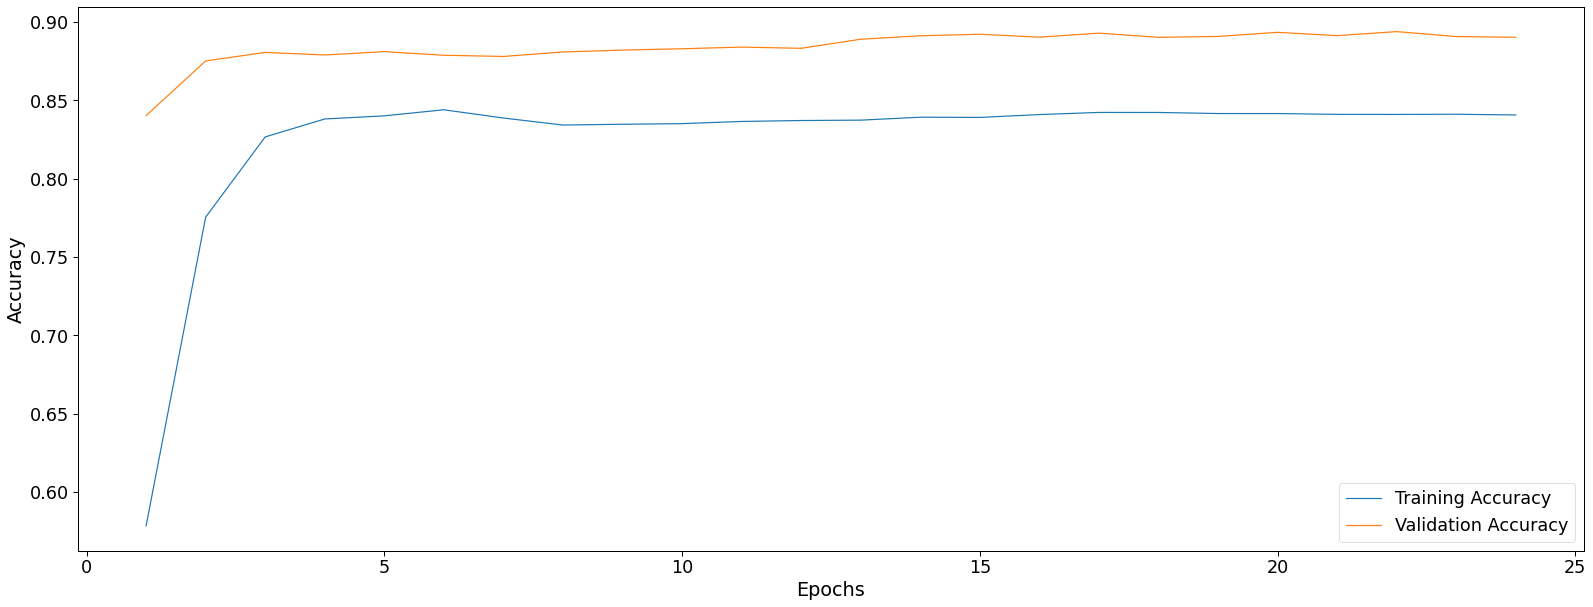

DNN_20_15_15_15_8_oboa.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_5 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_8 (Dense)             

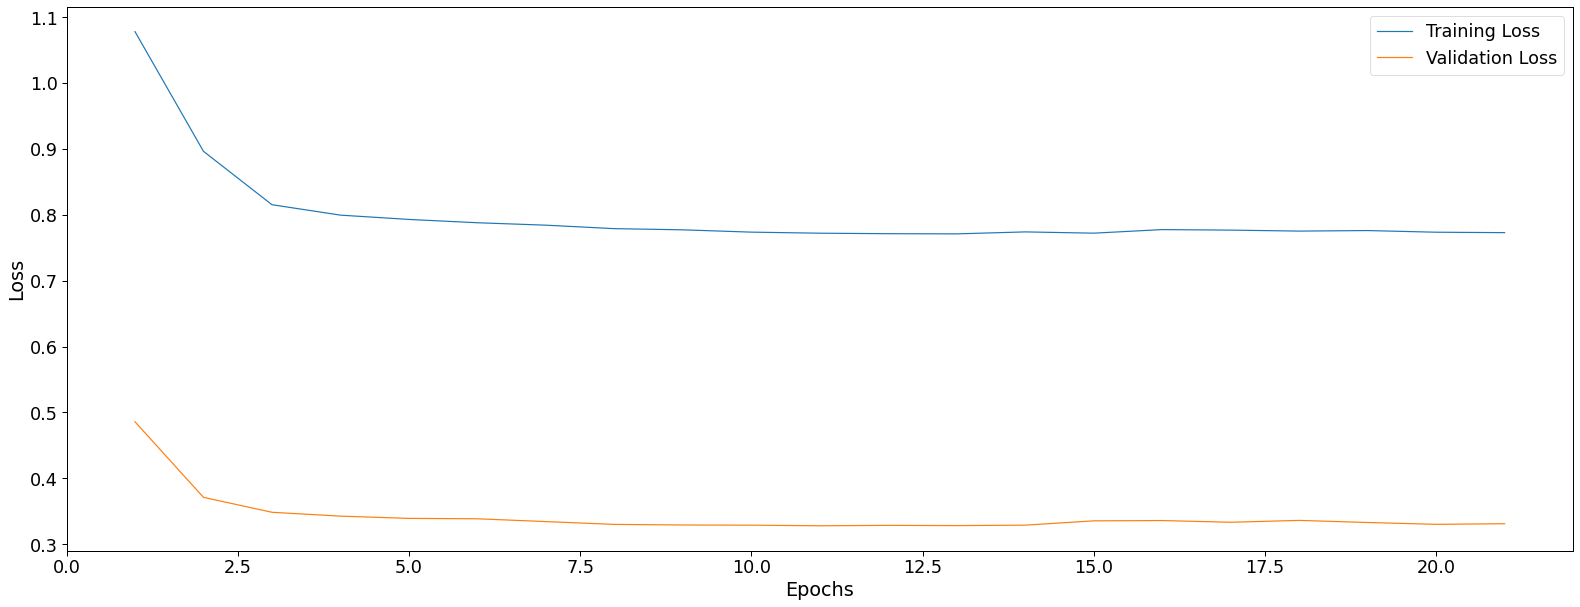

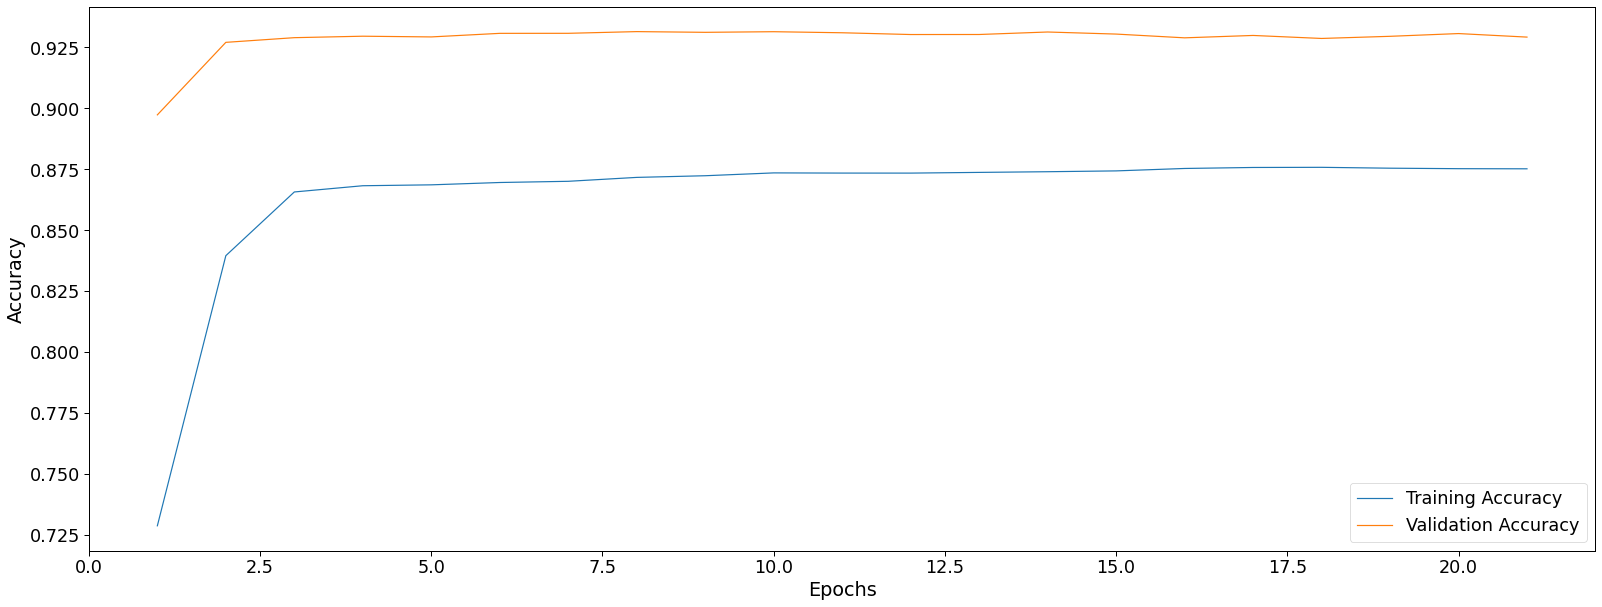

In [4]:
X_train = np.load(folder_oboa+'X_train.npy')
X_val = np.load(folder_oboa+'X_val.npy')
y_train = np.load(folder_oboa+'y_train.npy')
y_val = np.load(folder_oboa+'y_val.npy')

for NN in range(0, len(NNs)):
    dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    print(dnn_file)
    
    weights = {0:1, 1:5}
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
    es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
    opt = Adam(learning_rate=lr)

    DNN = Sequential()
    for c in range(0,len(NNs[NN])):
        if c == 0:
            DNN.add(Dense(NNs[NN][0], input_dim=len(X_train[0]), activation='relu'))
            DNN.add(Dropout(0.5))
        else:
            DNN.add(Dense(NNs[NN][c], activation='relu'))
            DNN.add(Dropout(0.5))
    DNN.add(Dense(1, activation='sigmoid'))
    DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
    DNN.summary()
    train_DNN = DNN.fit(X_train, y_train, epochs=epochsz, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True, callbacks=[es])#reduce_lr
    DNN.save(dnnfolder+dnn_file)
    training_report(train_DNN)

DNN_20_15_15_8_rboa.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_10 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_11 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_14 (Dense)             (N

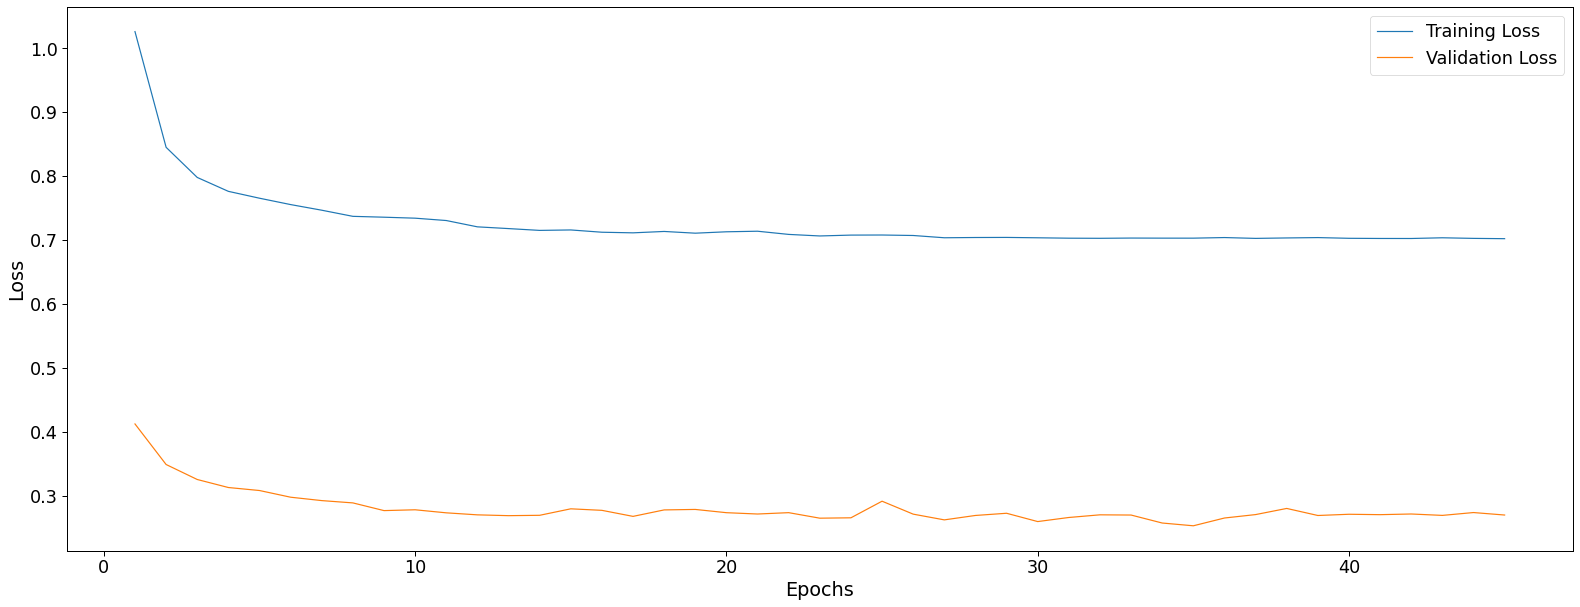

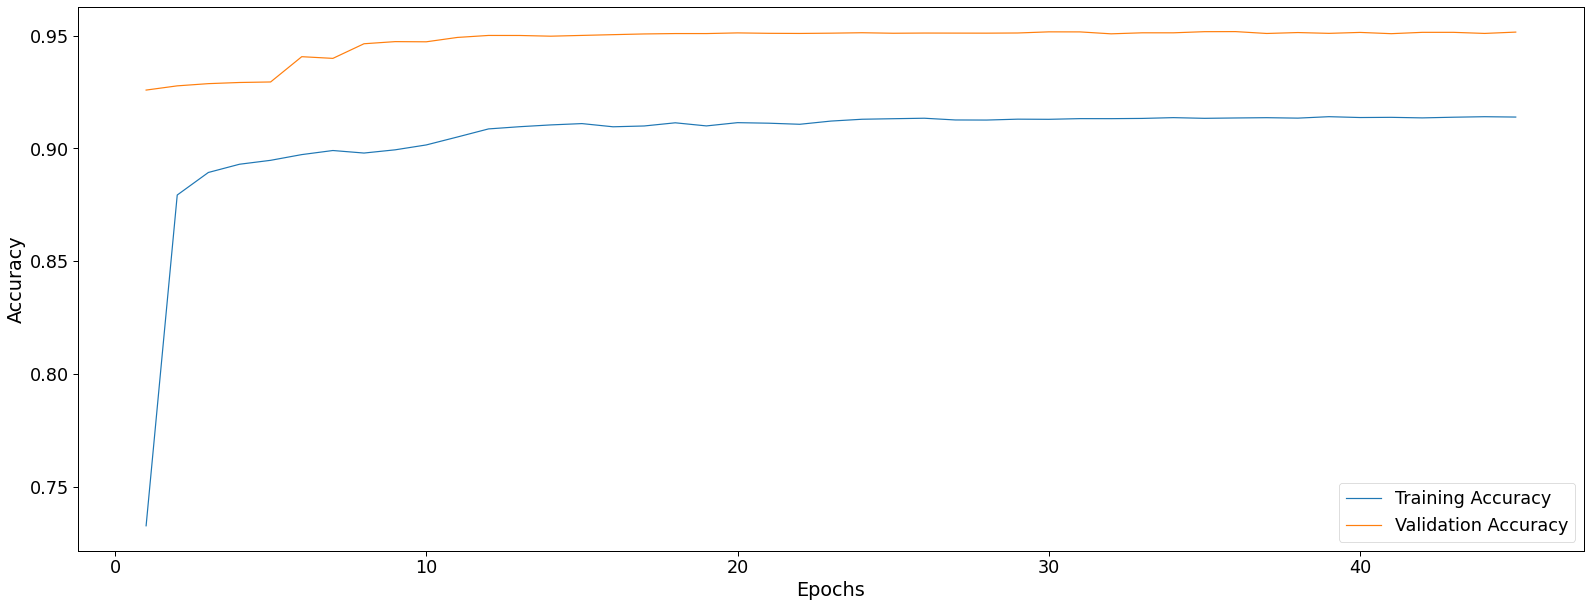

DNN_20_15_15_15_8_rboa.h5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_14 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_15 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_19 (Dense)            

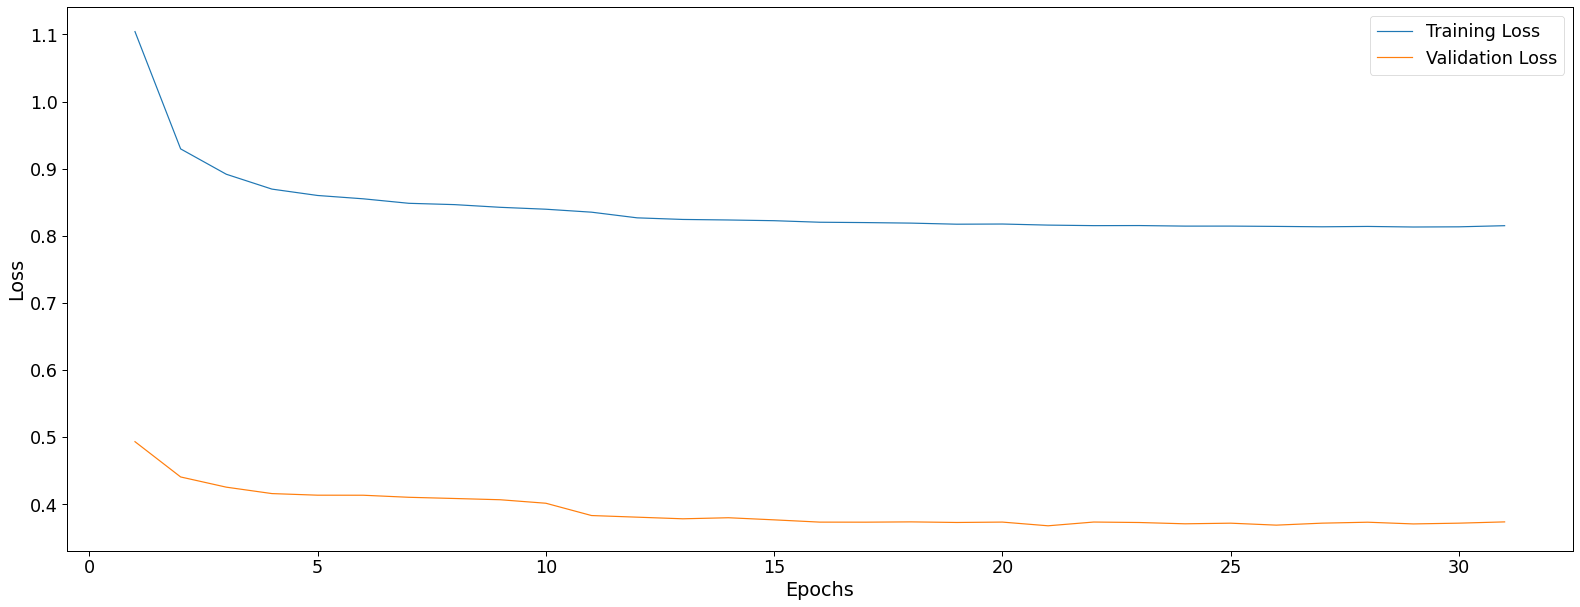

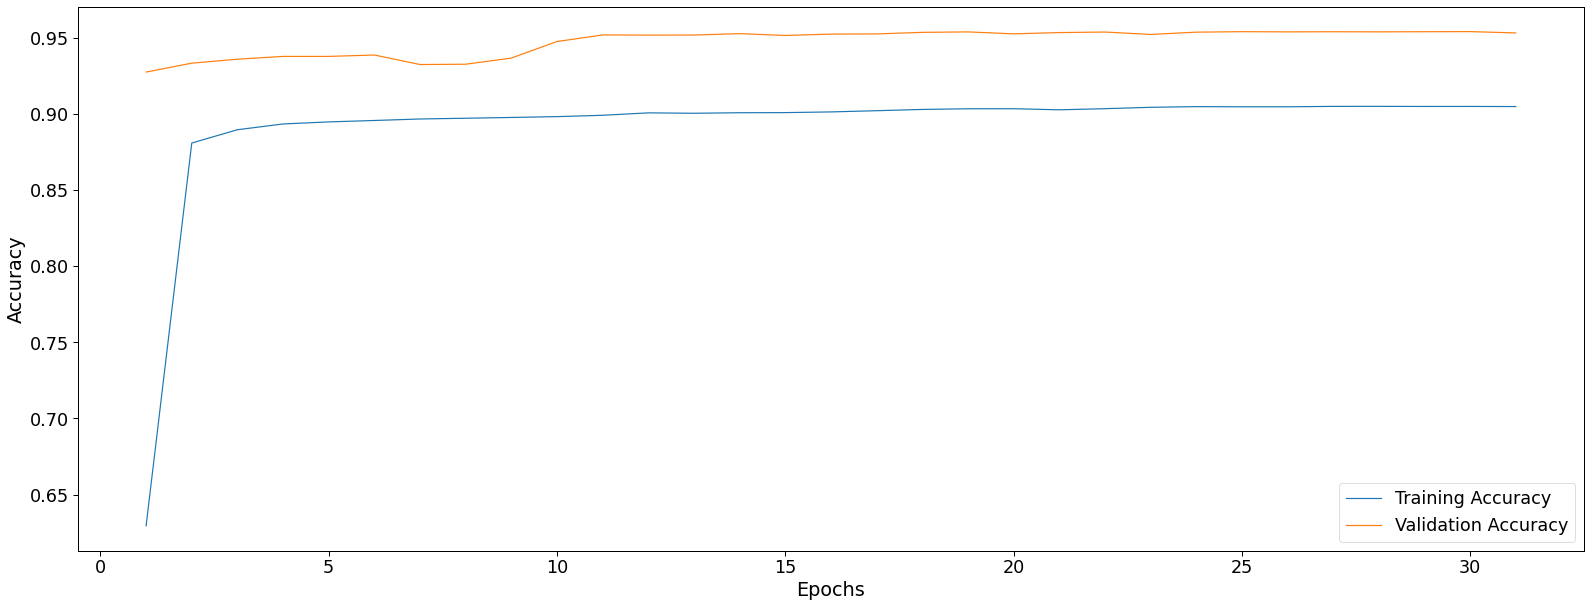

In [5]:
X_train = np.load(folder_rboa+'X_train.npy')
X_val = np.load(folder_rboa+'X_val.npy')
y_train = np.load(folder_rboa+'y_train.npy')
y_val = np.load(folder_rboa+'y_val.npy')

for NN in range(0, len(NNs)):

    dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    print(dnn_file)
    
    weights = {0:1, 1:5}
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
    es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
    opt = Adam(learning_rate=1e-4)

    DNN = Sequential()
    for c in range(0,len(NNs[NN])):
        if c == 0:
            DNN.add(Dense(NNs[NN][0], input_dim=len(X_train[0]), activation='relu'))
            DNN.add(Dropout(0.5))
        else:
            DNN.add(Dense(NNs[NN][c], activation='relu'))
            DNN.add(Dropout(0.5))
    DNN.add(Dense(1, activation='sigmoid'))
    DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
    DNN.summary()
    train_DNN = DNN.fit(X_train, y_train, epochs=epochsz, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True ,callbacks=[es])#reduce_lr
    DNN.save(dnnfolder+dnn_file)
    training_report(train_DNN)

# Test Set

-----------------------------------------


DNN_20_15_15_8_oboa.h5 

DNN_20_15_15_8_rboa.h5 

OBOA: ROC AUC=0.924
RBOA: ROC AUC=0.989
Random: ROC AUC=0.500


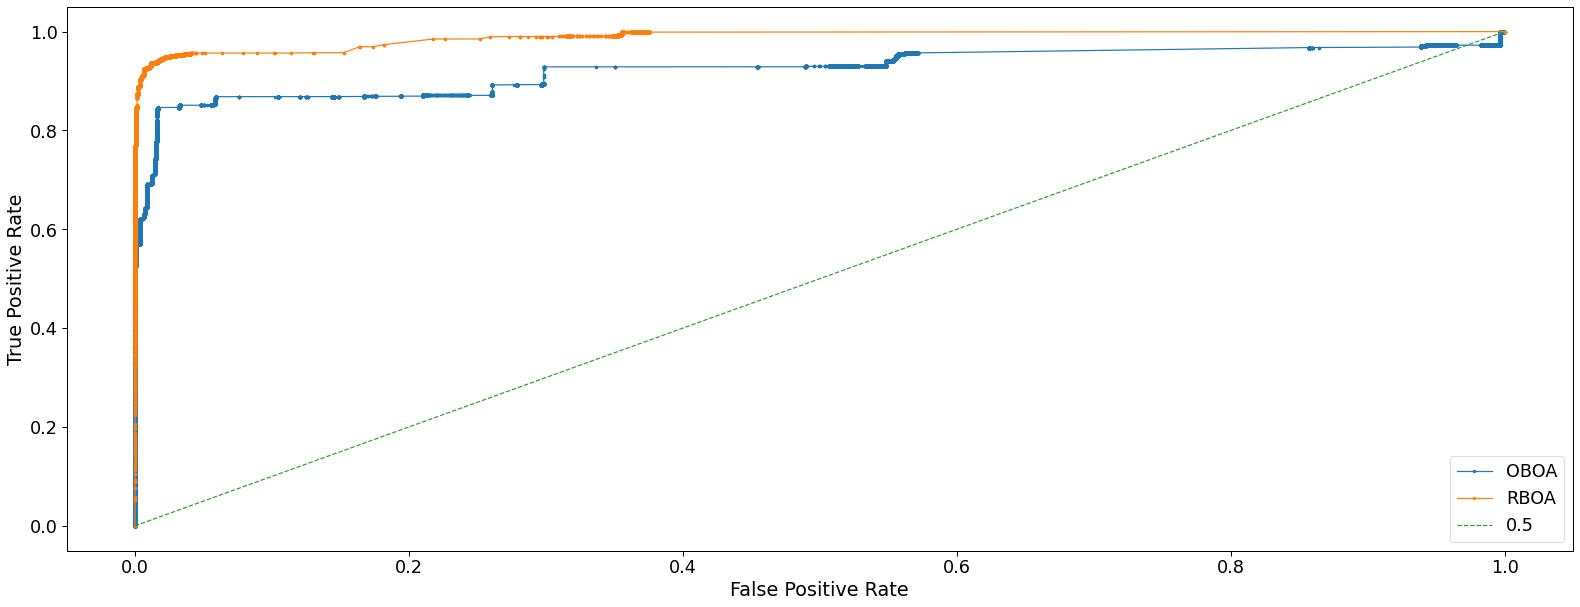

OBOA
[[ 859235 1055775]
 [  28309  450443]]


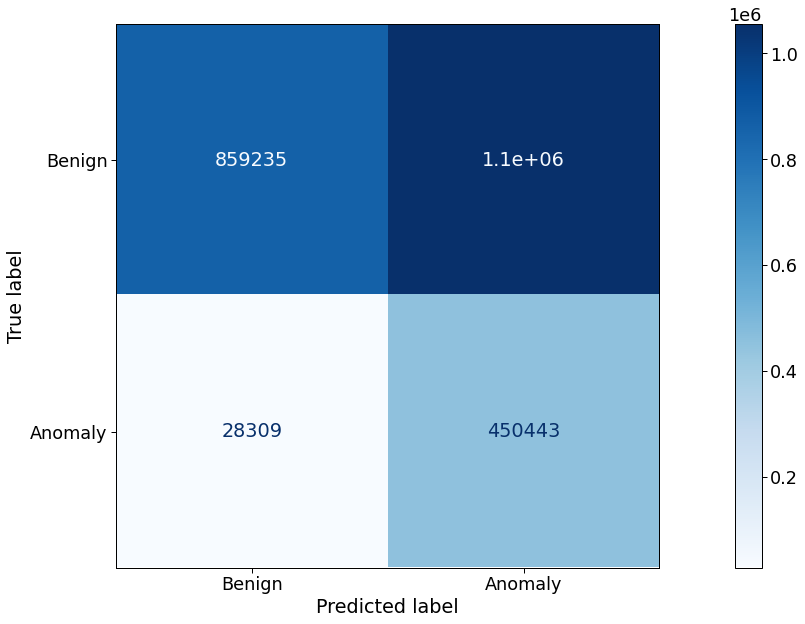

accuracy:  0.5471212259197029
f1:  0.4538537106354253
precision:  0.29905564798721035
recall:  0.9408691765256333
mcc:  0.3226035121136978
RBOA
[[1898891   16117]
 [  35501  443251]]


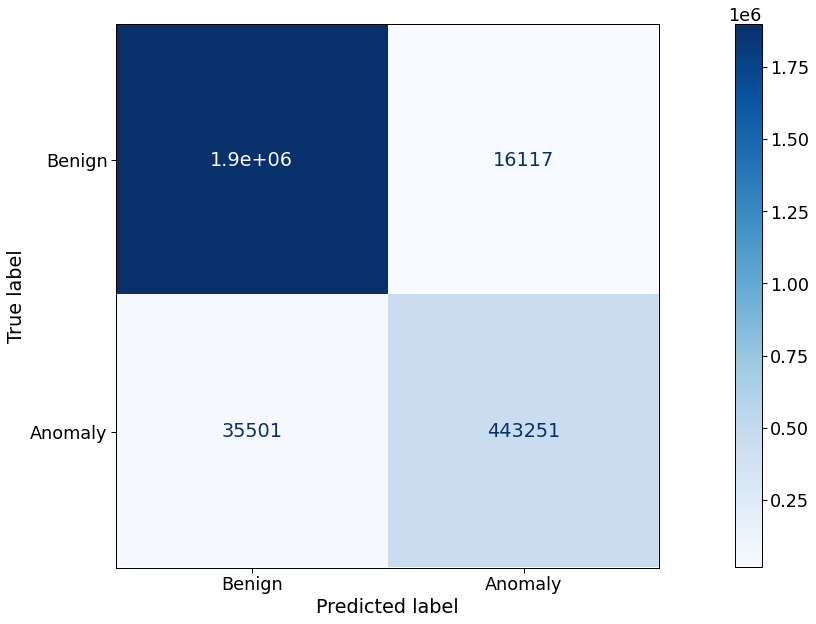

accuracy:  0.9784364347302987
f1:  0.944977188419392
precision:  0.964914839518643
recall:  0.9258467849742664
mcc:  0.9318826384904096
-----------------------------------------


DNN_20_15_15_15_8_oboa.h5 

DNN_20_15_15_15_8_rboa.h5 

OBOA: ROC AUC=0.933
RBOA: ROC AUC=0.977
Random: ROC AUC=0.500


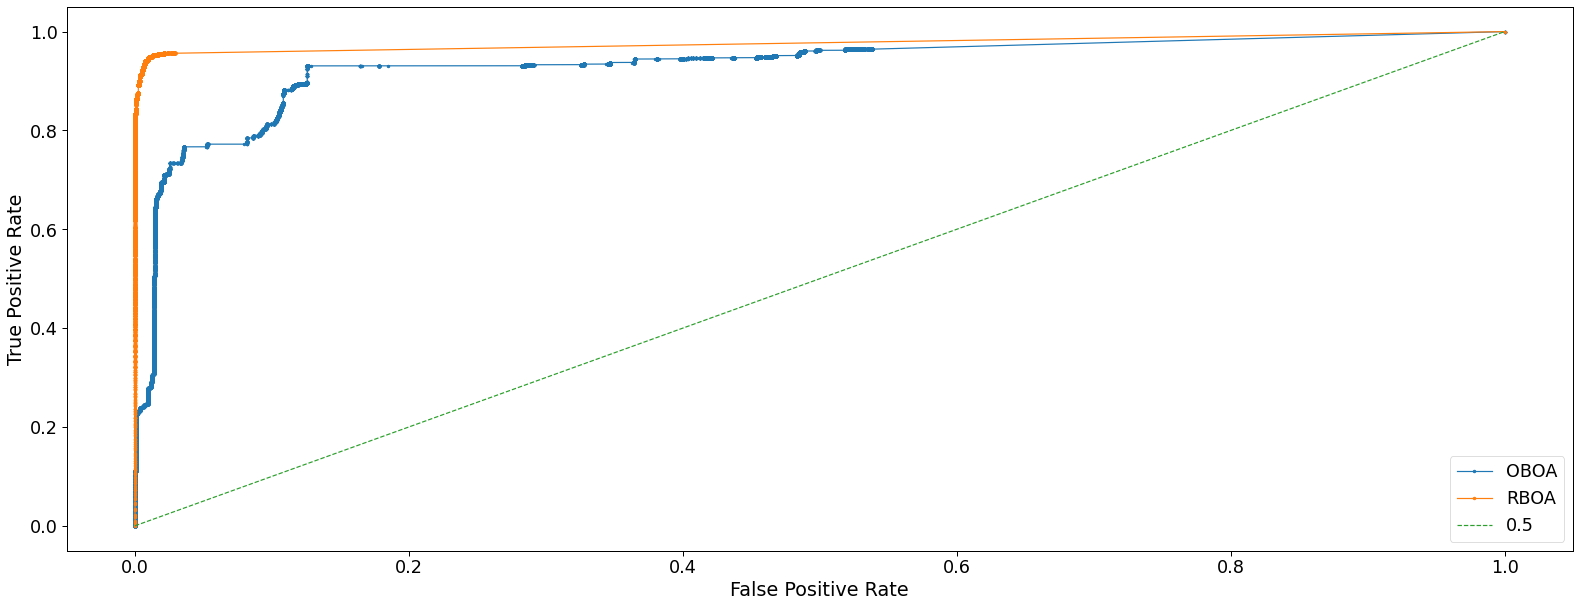

OBOA
[[1716162  198848]
 [  83705  395047]]


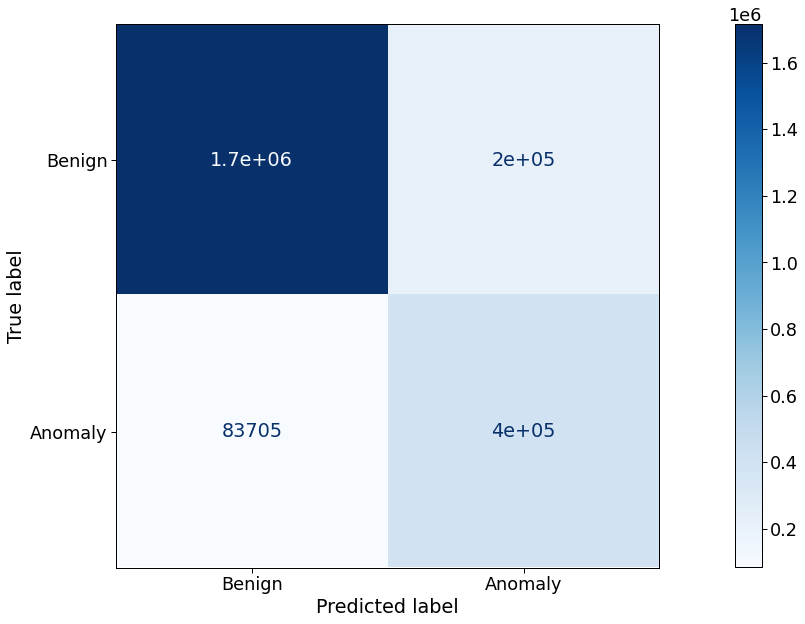

accuracy:  0.8819627849385193
f1:  0.7365834239968974
precision:  0.6651798718628714
recall:  0.8251599993315955
mcc:  0.6680298100110783
RBOA
[[1900353   14655]
 [  28958  449794]]


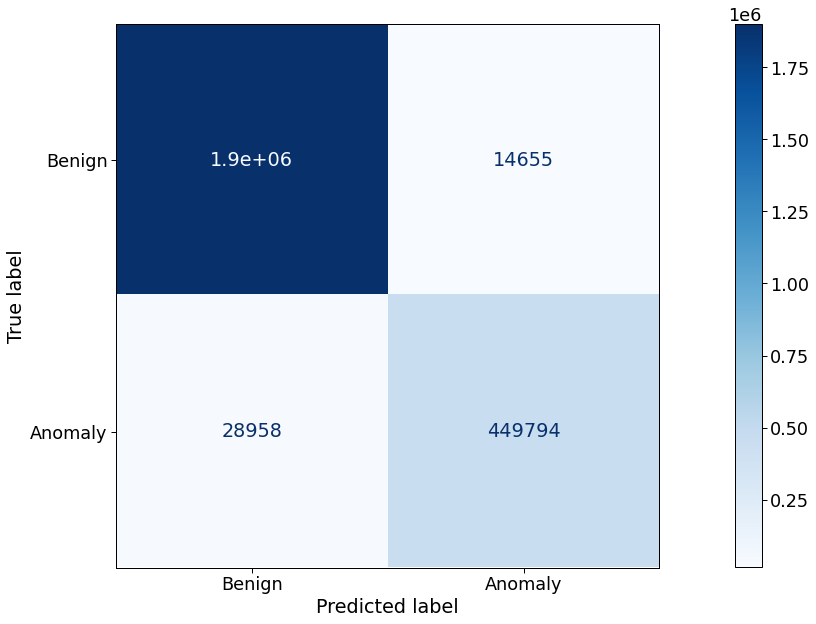

accuracy:  0.9817805460864916
f1:  0.9537606512291655
precision:  0.9684464817450356
recall:  0.9395135686117239
mcc:  0.9425871852054848


In [6]:
X_1_oboa = np.load(folder_oboa +'X_test.npy')
y_1_oboa = np.load(folder_oboa +'y_test.npy')

X_1_rboa = np.load(folder_rboa +'X_test.npy')
y_1_rboa = np.load(folder_rboa +'y_test.npy')

for NN in range(0, len(NNs)):
    print('-----------------------------------------\n\n')
    dnn_file_oboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    dnn_file_rboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    
    print(dnn_file_oboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_oboa)
    y_pred_oboa = DNN.predict(X_1_oboa)
    y_predr_oboa = np.rint(y_pred_oboa)
    print(dnn_file_rboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_rboa)
    y_pred_rboa = DNN.predict(X_1_rboa)
    y_predr_rboa = np.rint(y_pred_rboa)
    
    plot_roc_auc(y_1_oboa, y_1_rboa, y_pred_oboa, y_pred_rboa)
    
    print('OBOA')
    test_report(y_1_oboa ,y_predr_oboa)
    
    print('RBOA')
    test_report(y_1_rboa ,y_predr_rboa)
    

# AR Test Set (Benign Equalized)

-----------------------------------------


DNN_20_15_15_8_oboa.h5 

DNN_20_15_15_8_rboa.h5 

OBOA: ROC AUC=0.840
RBOA: ROC AUC=0.887
Random: ROC AUC=0.500


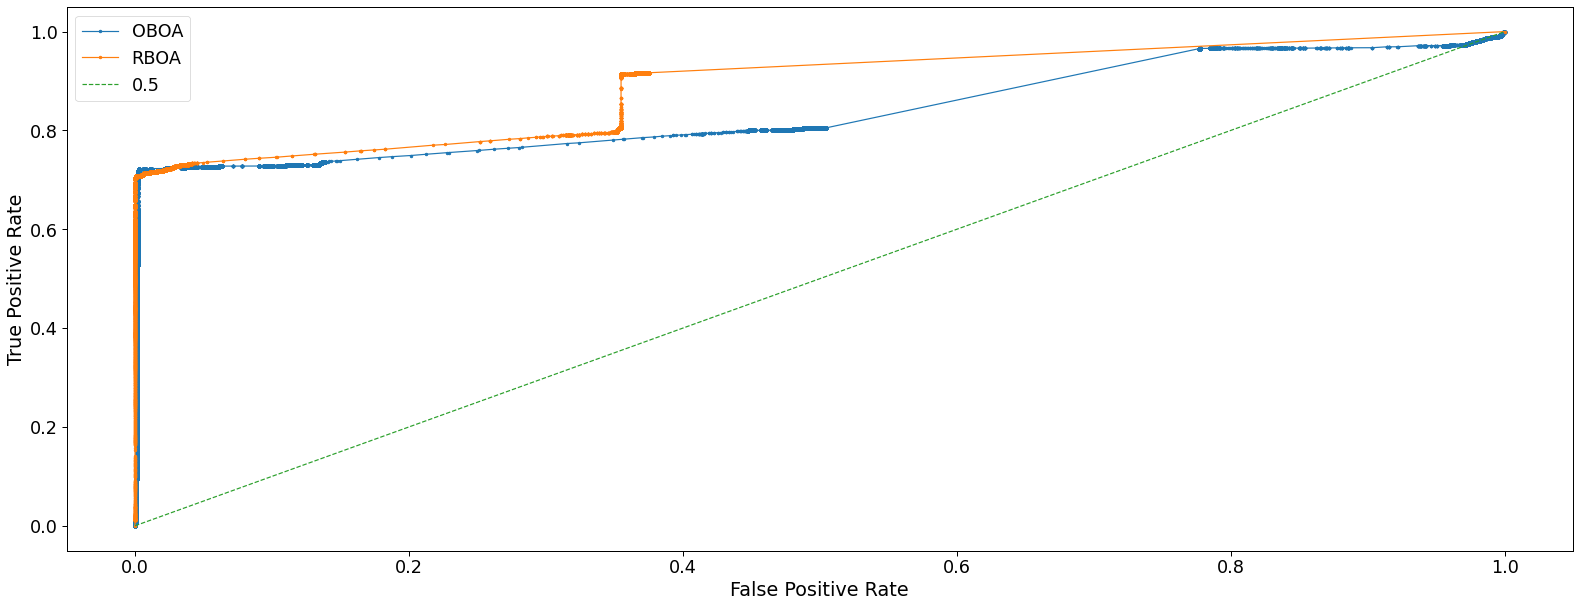

OBOA
[[5143886 4876963]
 [ 142543  582231]]


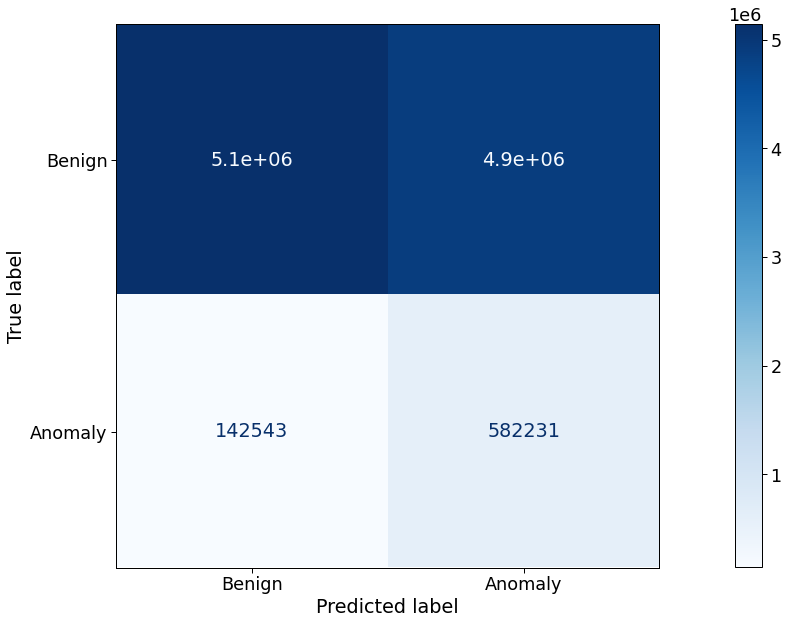

accuracy:  0.5328790150184871
f1:  0.1883033676759
precision:  0.10665145807238212
recall:  0.8033276580009768
mcc:  0.15884814868983468
attack                    misclassification
Brute Force -Web          0                       301
                          1                      1842
Brute Force -XSS          0                       136
                          1                       791
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432488
                          1                       160
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                     55678
                          1                     60683
SQL Injection             0                        60
                          1                       372
SSH-Bruteforce            0                     16284
         

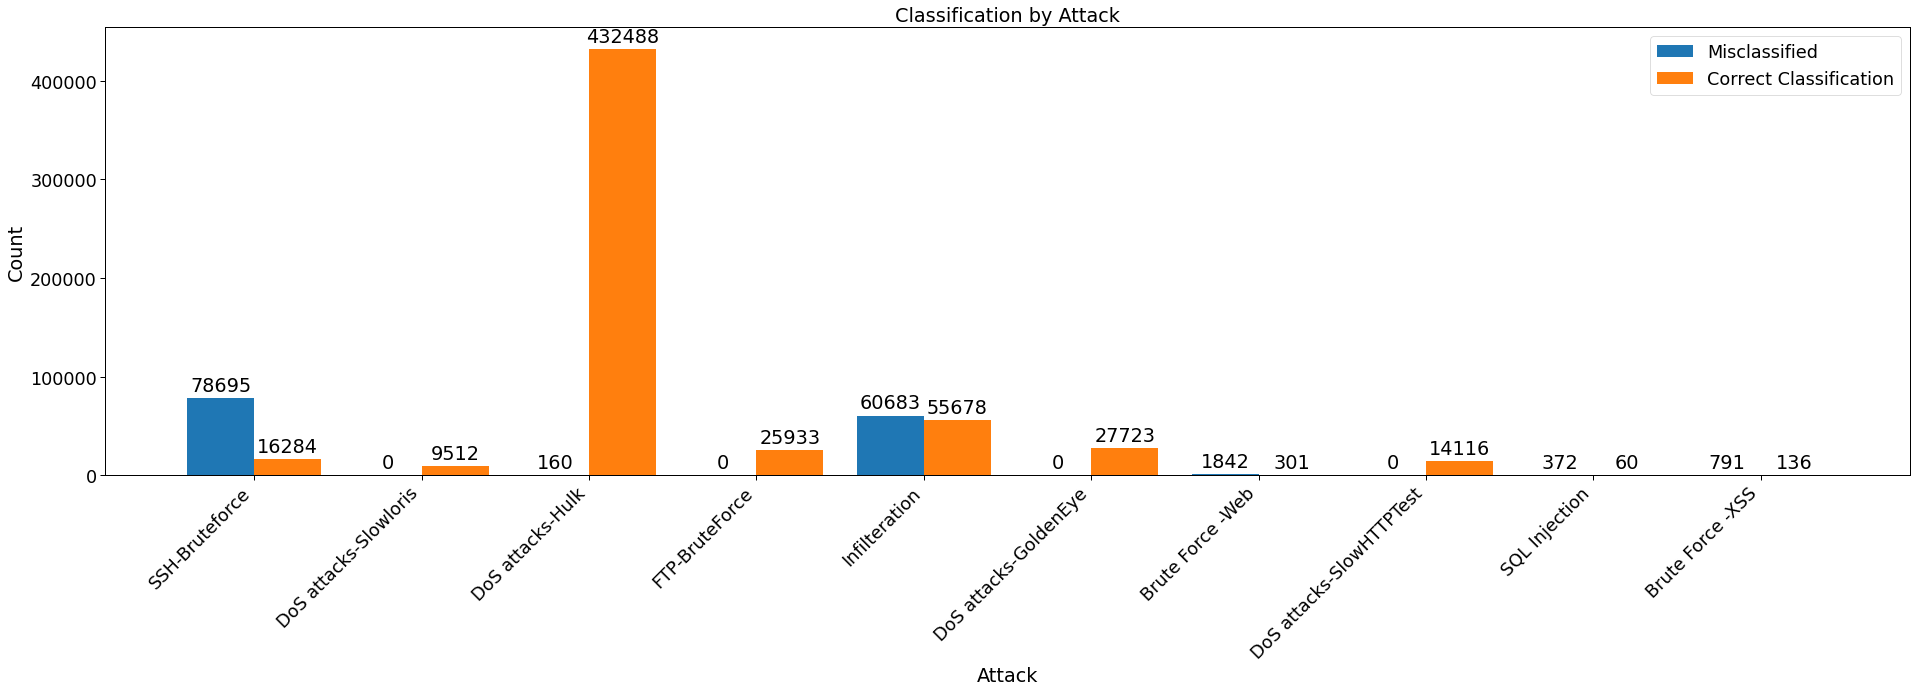

RBOA
[[9935559   85290]
 [ 207363  517411]]


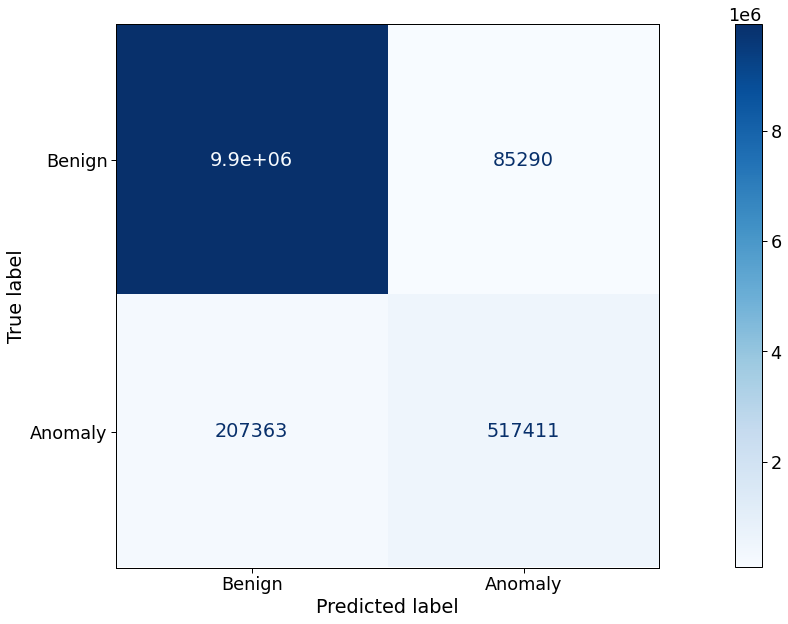

accuracy:  0.9727653761908454
f1:  0.7795416109531254
precision:  0.8584870441562235
recall:  0.7138928824709496
mcc:  0.768856351858118
attack                    misclassification
Brute Force -Web          0                       146
                          1                      1997
Brute Force -XSS          0                       120
                          1                       807
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432644
                          1                         4
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                      5049
                          1                    111312
SQL Injection             1                       432
SSH-Bruteforce            0                      2168
                          1                     92811
dtype: in

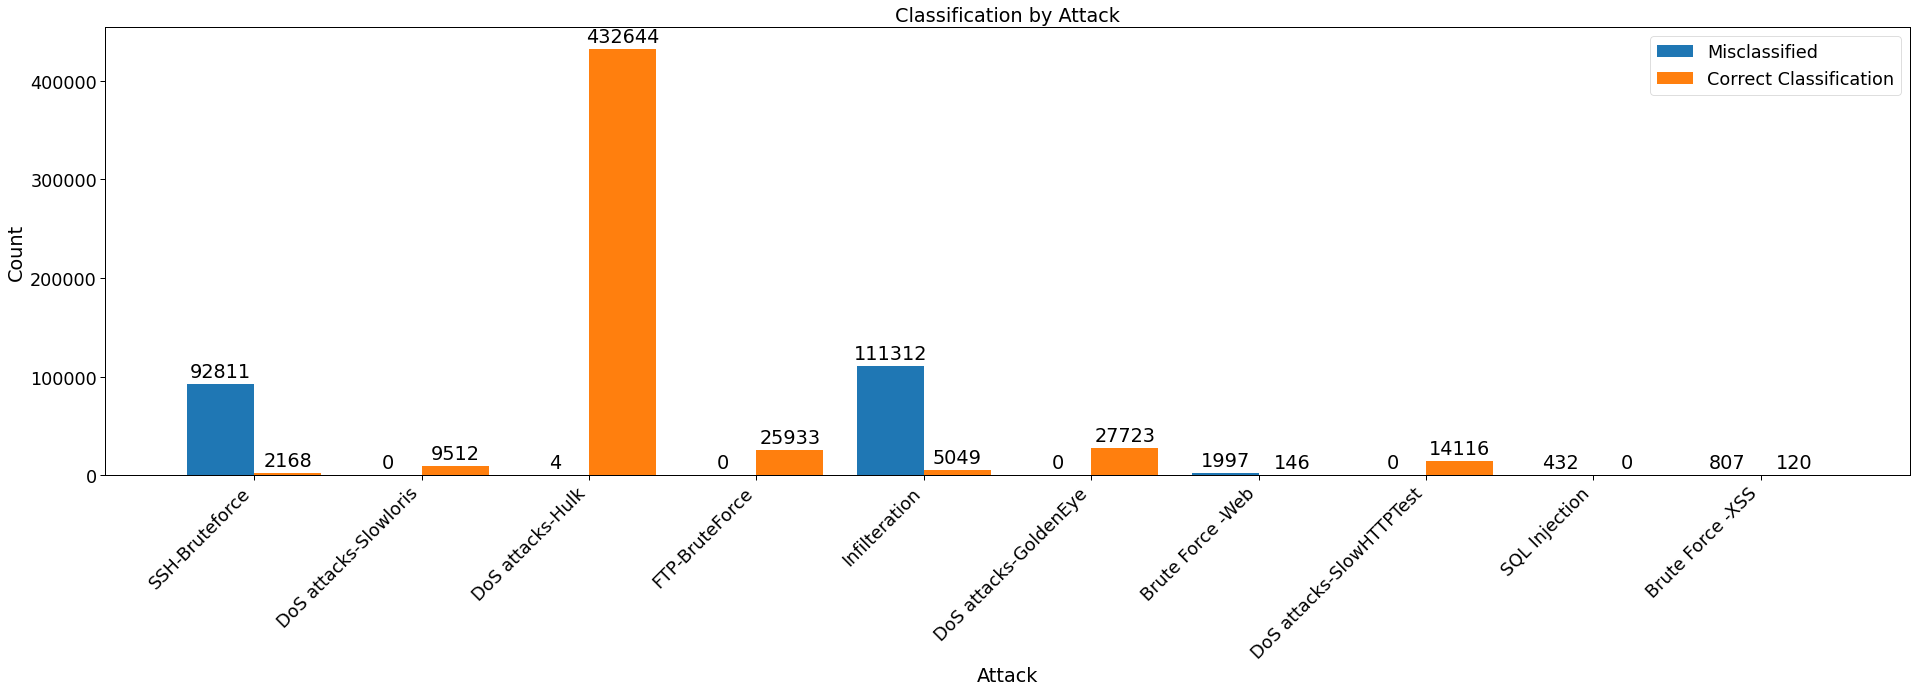

-----------------------------------------


DNN_20_15_15_15_8_oboa.h5 

DNN_20_15_15_15_8_rboa.h5 

OBOA: ROC AUC=0.894
RBOA: ROC AUC=0.915
Random: ROC AUC=0.500


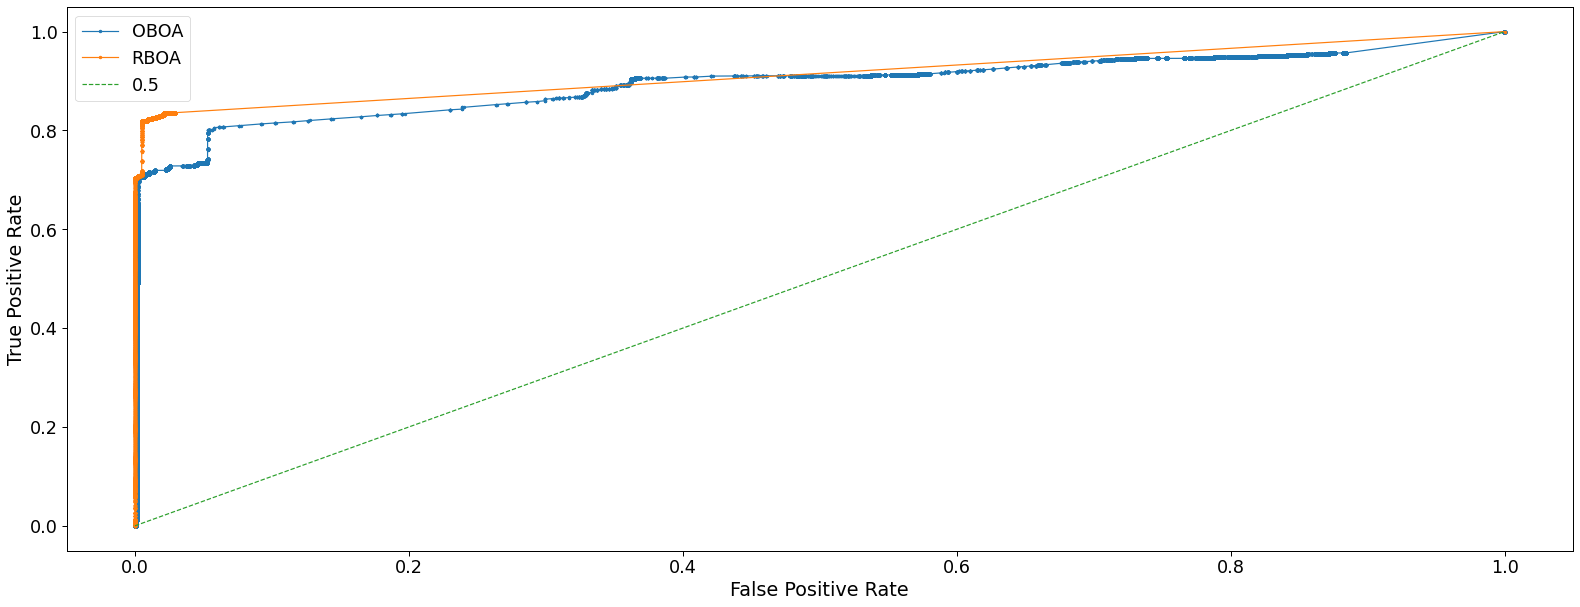

OBOA
[[9921226   99623]
 [ 208362  516412]]


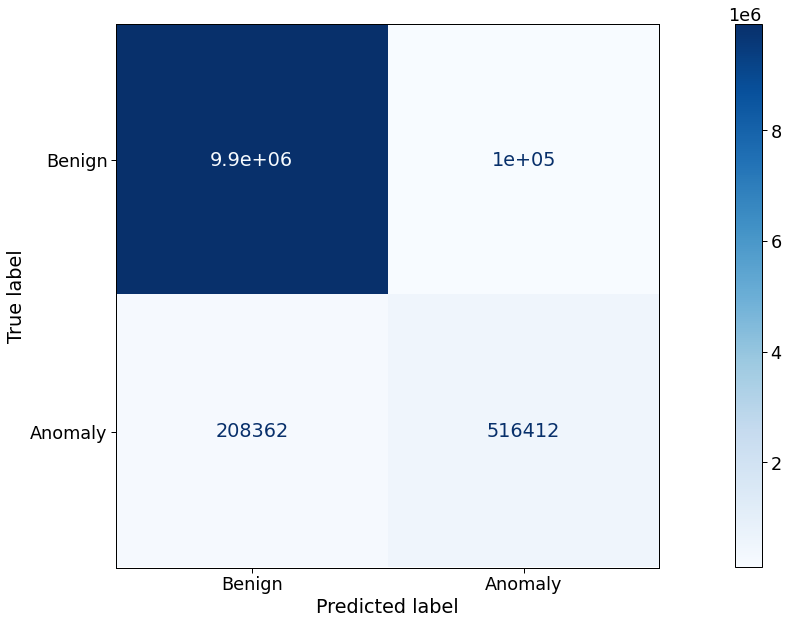

accuracy:  0.9713385626873379
f1:  0.7702991253787825
precision:  0.8382835390846299
recall:  0.712514521768165
mcc:  0.757960199475791
attack                    misclassification
Brute Force -Web          0                      1828
                          1                       315
Brute Force -XSS          0                       776
                          1                       151
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432315
                          1                       333
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                       971
                          1                    115390
SQL Injection             0                       372
                          1                        60
SSH-Bruteforce            0                      2866
          

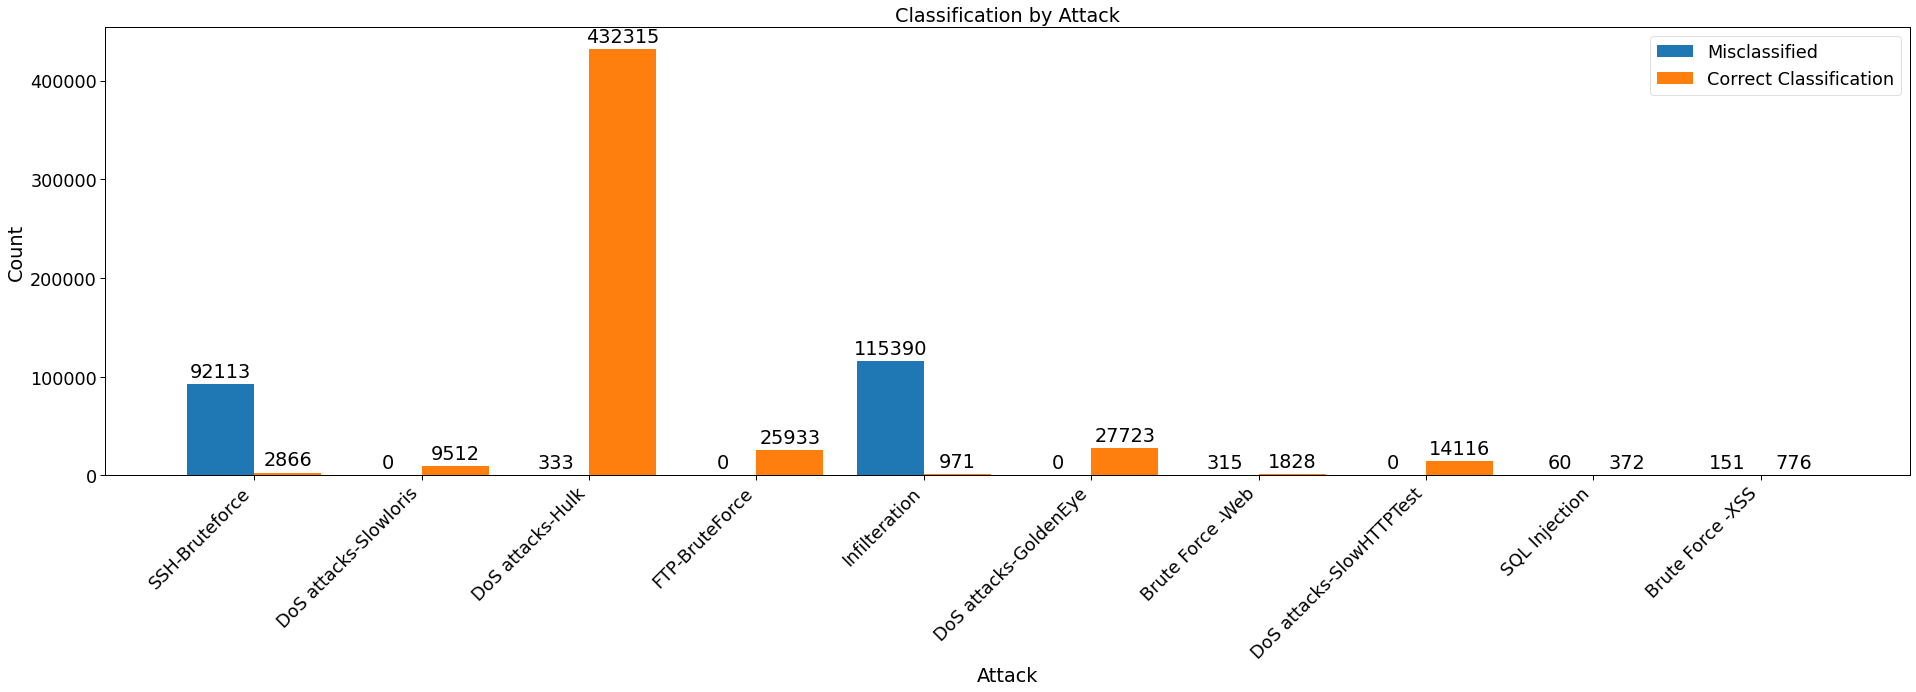

RBOA
[[9942516   78333]
 [ 130462  594312]]


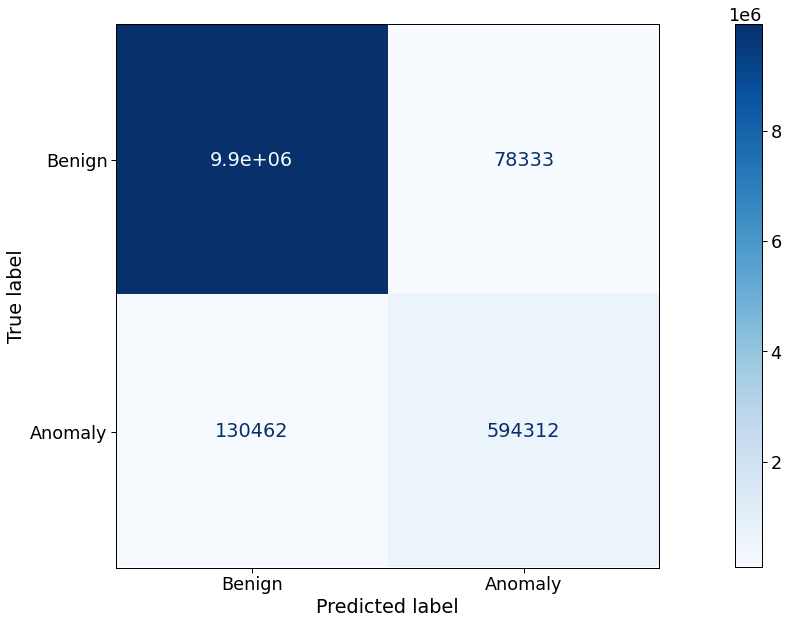

accuracy:  0.9805692978434103
f1:  0.8505852575354994
precision:  0.8835448118992931
recall:  0.8199963022956122
mcc:  0.8408791348509841
attack                    misclassification
Brute Force -Web          0                         1
                          1                      2142
Brute Force -XSS          1                       927
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432535
                          1                       113
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7284
                          1                      2228
FTP-BruteForce            0                     25933
Infilteration             0                      5839
                          1                    110522
SQL Injection             1                       432
SSH-Bruteforce            0                     80881
                          1                     14098
dtype: i

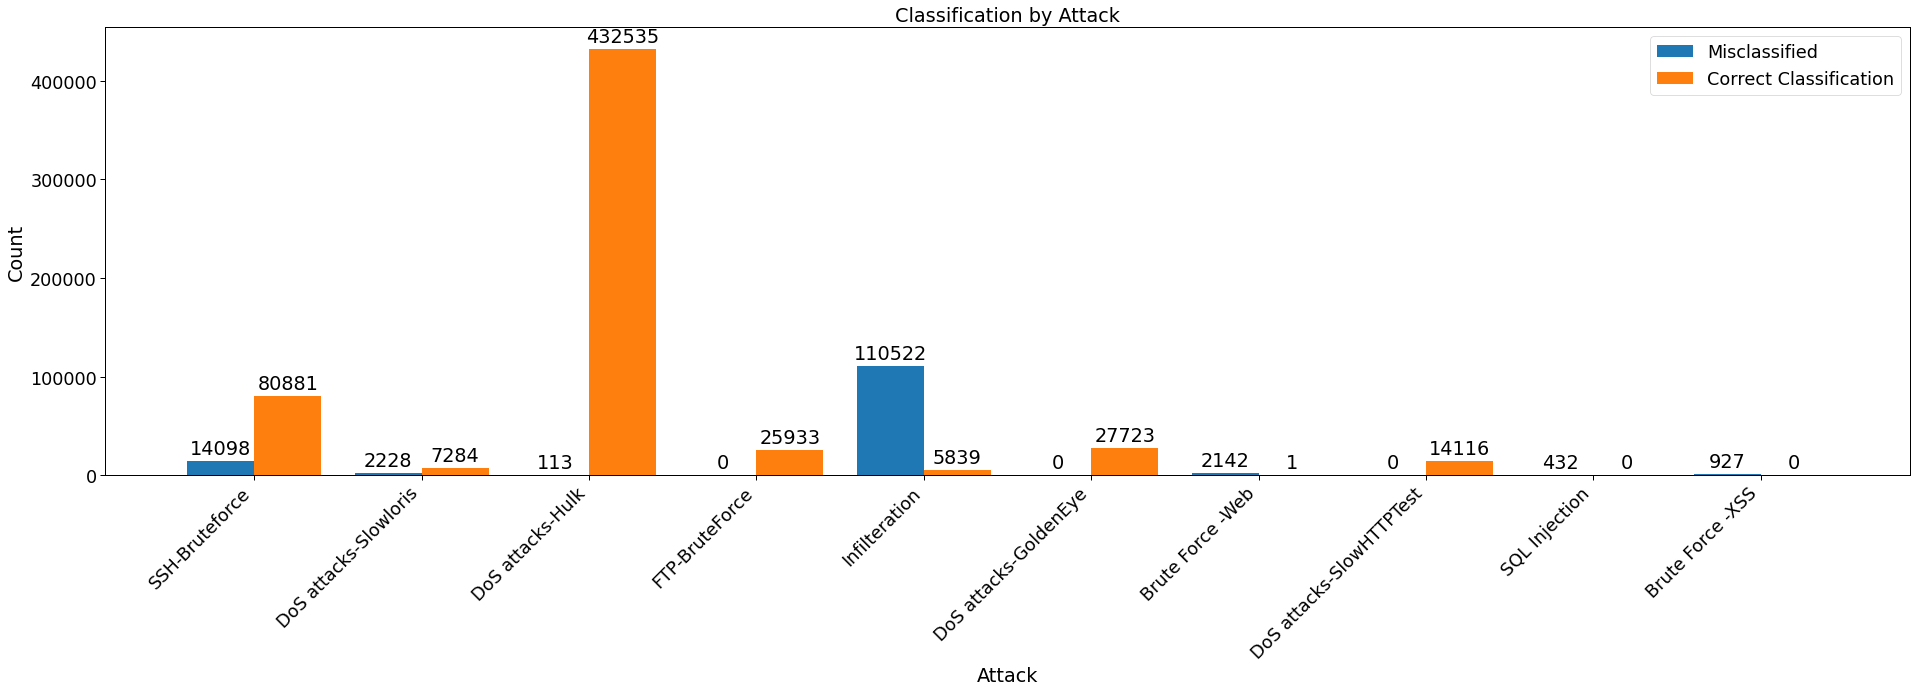

In [7]:
X_1_oboa = np.load(folder_oboa +'X_1_ar.npy')
y_1_oboa = np.load(folder_oboa +'y_1_ar.npy')
a_1_oboa = np.load(folder_oboa +'a_1_ar.npy', allow_pickle=True)

X_1_rboa = np.load(folder_rboa +'X_1_ar.npy')
y_1_rboa = np.load(folder_rboa +'y_1_ar.npy')
a_1_rboa = np.load(folder_rboa +'a_1_ar.npy', allow_pickle=True)

for NN in range(0, len(NNs)):
    print('-----------------------------------------\n\n')
    dnn_file_oboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    dnn_file_rboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    
    print(dnn_file_oboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_oboa)
    y_pred_oboa = DNN.predict(X_1_oboa)
    y_predr_oboa = np.rint(y_pred_oboa)
    print(dnn_file_rboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_rboa)
    y_pred_rboa = DNN.predict(X_1_rboa)
    y_predr_rboa = np.rint(y_pred_rboa)
    
    plot_roc_auc(y_1_oboa, y_1_rboa, y_pred_oboa, y_pred_rboa)
    
    print('OBOA')
    test_report(y_1_oboa ,y_predr_oboa)
    attack_report(y_1_oboa, y_predr_oboa, a_1_oboa)
    
    print('RBOA')
    test_report(y_1_rboa ,y_predr_rboa)
    attack_report(y_1_rboa, y_predr_rboa, a_1_rboa)
    
  